Today, we will be doing the following:
* encode `tanh` activation functions and learn weights for the functions in the partitioned and unpartitioned models
* Try out `dropout`, $L_2$, and `weight decay` regularization methods for the partitioned and unpartitioned models  

In [1]:
from tqdm import tqdm_notebook as tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  

In [2]:
BATCH_SIZE = 1000

# list all transformations
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081,))])

# download and load training dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=4)

# download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=4)

In [3]:
def onehotTensor(category,n_categories):
    tensor = torch.zeros(1, n_categories,dtype=torch.long)
    tensor[0][category] = 1
    return tensor
        
def get_accuracy(logit, target):
    batch_size = len(target)
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [0]:
class PRNN_LSTM(nn.Module):
    def __init__(self, n_inputs, n_hidden,n_output,mr):
        super(PRNN_LSTM, self).__init__()
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.decoder = nn.Linear(n_hidden, n_output)
        self.lstm = nn.LSTM(n_inputs, n_hidden)
        
    def forward(self, x0):
        x0=x0.permute(1,0,2)
        self.h1 = (torch.zeros(1,BATCH_SIZE,self.n_hidden),torch.zeros(1,BATCH_SIZE,self.n_hidden))
        self.y0, self.h1 = self.lstm(x0,self.h1)
        self.y1 = self.decoder(self.h1[0])
        
        return self.y1

In [0]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_HIDDEN = 100
N_OUTPUTS = 10
N_EPHOCS = 10

model = PRNN_LSTM(N_INPUTS,N_HIDDEN,N_OUTPUTS,0.1)

optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
criterion = nn.CrossEntropyLoss()

train_running_loss = np.zeros(N_EPHOCS)
train_acc = np.zeros(N_EPHOCS)
nparams = 0
for param in model.parameters(): 
  if param.requires_grad:
    nparams += param.data.numpy().size
Phist = np.zeros((nparams,N_EPHOCS))

for epoch in range(N_EPHOCS):
    nps = 0
    running_loss=0
    running_acc=0
    for p,param in enumerate(model.parameters()):
        if param.requires_grad:
            plist = param.data.numpy().flatten()
            for j in range(plist.size):
                Phist[nps,epoch]=plist[j]
                nps+=1
  
    for i, data in enumerate(trainloader):
        
        optimizer.zero_grad()
        x, y_tar = data
        y_pred = model(x.view(BATCH_SIZE,N_STEPS,N_INPUTS))
        loss = criterion(y_pred.view(BATCH_SIZE,N_OUTPUTS),y_tar)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        running_acc+=get_accuracy(y_pred.view(BATCH_SIZE,N_OUTPUTS), y_tar)
    train_running_loss[epoch] = running_loss
    train_acc[epoch] = running_acc/i
    
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' %(epoch, train_running_loss[epoch], train_acc[epoch]))

Epoch:  0 | Loss: 350.1357 | Train Accuracy: 79.85
Epoch:  1 | Loss: 67.6076 | Train Accuracy: 96.79
Epoch:  2 | Loss: 47.2616 | Train Accuracy: 97.78
Epoch:  3 | Loss: 36.6523 | Train Accuracy: 98.32
Epoch:  4 | Loss: 30.6226 | Train Accuracy: 98.60
Epoch:  5 | Loss: 25.1116 | Train Accuracy: 98.87
Epoch:  6 | Loss: 21.1064 | Train Accuracy: 99.08
Epoch:  7 | Loss: 18.7756 | Train Accuracy: 99.20
Epoch:  8 | Loss: 14.6571 | Train Accuracy: 99.38
Epoch:  9 | Loss: 13.6058 | Train Accuracy: 99.46


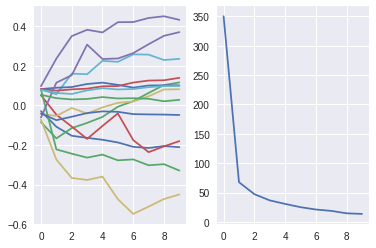

In [0]:
plt.subplot(1,2,1)
plt.plot(Phist[::4000,:].T)
plt.subplot(1,2,2)
plt.plot(train_running_loss)
plt.show()

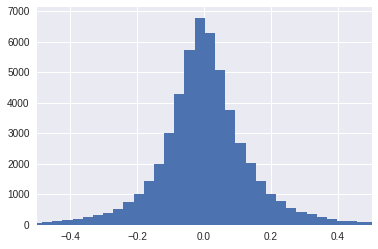

In [0]:
dw = Phist[:,-1]-Phist[:,0]
plt.hist(dw,100)
plt.xlim(-.5,.5)
plt.show()

In [0]:
class PRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden,n_output,mr):
        super(PRNN, self).__init__()
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.decoder = nn.Linear(n_hidden, n_output)
        self.rnn = nn.RNN(n_inputs, n_hidden)
        
    def forward(self, x0):
        x0=x0.permute(1,0,2)
        self.h1 = torch.zeros(1,BATCH_SIZE,self.n_hidden)
        self.y0, self.h1 = self.rnn(x0,self.h1)
        self.y1 = self.decoder(self.h1[0])
        
        return self.y1

In [0]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_HIDDEN = 100
N_OUTPUTS = 10
N_EPHOCS = 10

model = PRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,0.1)

optimizer = torch.optim.SGD(model.parameters(), lr=5e-3, momentum=0.9)
criterion = nn.CrossEntropyLoss()

train_running_loss = np.zeros(N_EPHOCS)
train_acc = np.zeros(N_EPHOCS)
nparams = 0
for param in model.parameters(): 
  if param.requires_grad:
    nparams += param.data.numpy().size
Phist = np.zeros((nparams,N_EPHOCS))

for epoch in range(N_EPHOCS):
    nps = 0
    running_loss=0
    running_acc=0
    for p,param in enumerate(model.parameters()):
        if param.requires_grad:
            plist = param.data.numpy().flatten()
            for j in range(plist.size):
                Phist[nps,epoch]=plist[j]
                nps+=1
  
    for i, data in enumerate(trainloader):
        
        optimizer.zero_grad()
        x, y_tar = data
        y_pred = model(x.view(BATCH_SIZE,N_STEPS,N_INPUTS))
        loss = criterion(y_pred.view(BATCH_SIZE,N_OUTPUTS),y_tar)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        running_acc+=get_accuracy(y_pred.view(BATCH_SIZE,N_OUTPUTS), y_tar)
    train_running_loss[epoch] = running_loss
    train_acc[epoch] = running_acc/i
    
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' %(epoch, train_running_loss[epoch], train_acc[epoch]))

Epoch:  0 | Loss: 742.3004 | Train Accuracy: 57.43
Epoch:  1 | Loss: 260.9732 | Train Accuracy: 87.56
Epoch:  2 | Loss: 186.4463 | Train Accuracy: 91.53
Epoch:  3 | Loss: 152.7099 | Train Accuracy: 93.06
Epoch:  4 | Loss: 126.6347 | Train Accuracy: 94.33
Epoch:  5 | Loss: 113.1902 | Train Accuracy: 94.96
Epoch:  6 | Loss: 101.7073 | Train Accuracy: 95.41
Epoch:  7 | Loss: 94.5592 | Train Accuracy: 95.90
Epoch:  8 | Loss: 93.1100 | Train Accuracy: 95.88
Epoch:  9 | Loss: 81.7757 | Train Accuracy: 96.42


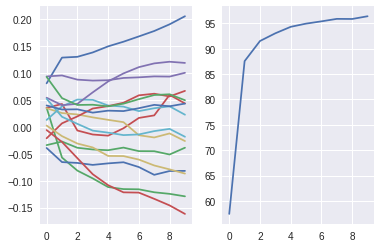

In [0]:
plt.subplot(1,2,1)
plt.plot(Phist[::1000,:].T)
plt.subplot(1,2,2)
plt.plot(train_acc)
plt.show()

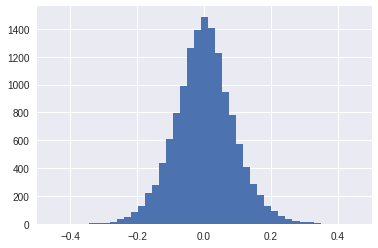

In [0]:
dw = Phist[:,-1]-Phist[:,0]
plt.hist(dw,40)
plt.xlim(-0.5,0.5)
plt.show()

In [0]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_HIDDEN = 56
N_OUTPUTS = 10
N_EPHOCS = 11
N_REPS = 1
lambdas = np.linspace(0,0.08,9)
N_LAMBDA = len(lambdas)
gidx = int(N_HIDDEN/2)

def nparam(ninputs,nhidden,noutputs):
    return ninputs*(nhidden+1) + nhidden*(nhidden+1)+nhidden*(noutputs+1)
N_PARAMS = nparam(N_INPUTS,N_HIDDEN,N_OUTPUTS)
  
train_running_loss = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
train_acc = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
Phist = np.zeros((N_PARAMS,N_EPHOCS,N_LAMBDA,N_REPS))

model =  [None] * N_LAMBDA*N_REPS
regval = []
for r in range(N_REPS):
    for k, reg_lambda in enumerate(lambdas):
        model[k+r*N_REPS] = PRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,0.1)
        optimizer = torch.optim.SGD(model[k+r*N_REPS].parameters(), lr=5e-3, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        print('lambda = {}'.format(reg_lambda))

        for epoch in range(N_EPHOCS):
            nps = 0
            running_loss=0
            running_acc=0
            for p,param in enumerate(model[k+r*N_REPS].parameters()):
                if param.requires_grad:
                    plist = param.data.numpy().flatten()
                    for j in range(plist.size):
                        Phist[nps,epoch,k,r]=plist[j]
                        nps+=1

            for i, data in enumerate(trainloader):
                optimizer.zero_grad()
                x, y_tar = data
                y_pred = model[k+r*N_REPS](x.view(BATCH_SIZE,N_STEPS,N_INPUTS))
                loss = criterion(y_pred.view(BATCH_SIZE,N_OUTPUTS),y_tar)
                l2_reg = Variable(torch.FloatTensor(1), requires_grad=True)
                for p,param in enumerate(model[k+r*N_REPS].parameters()):
                    if param.requires_grad and len(param.shape)==2:
                        if param.shape[0]==N_HIDDEN and param.shape[1]==N_HIDDEN:
                            l2_reg = l2_reg + param[:gidx,:gidx].norm(p=2)
                            l2_reg = l2_reg + param[gidx:,gidx:].norm(p=2)
                        elif param.shape[1]==N_HIDDEN:
                            l2_reg = l2_reg + param[:,gidx:].norm(p=2)
                        elif param.shape[0]==N_HIDDEN:
                            l2_reg = l2_reg + param[:gidx,:].norm(p=2)
                regval.append(l2_reg)
                loss = loss + l2_reg*reg_lambda
                loss.backward()
                optimizer.step()
                running_loss+=loss.item()
                running_acc+=get_accuracy(y_pred.view(BATCH_SIZE,N_OUTPUTS), y_tar, BATCH_SIZE)
            train_running_loss[epoch,k,r] = running_loss
            train_acc[epoch,k,r] = running_acc/i
            if epoch%10==0:
                print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' %(epoch, train_running_loss[epoch,k,r], train_acc[epoch,k,r]))

lambda = 0.0
Epoch:  0 | Loss: 540.4584 | Train Accuracy: 36.73
Epoch:  10 | Loss: 72.6635 | Train Accuracy: 93.46
lambda = 0.01
Epoch:  0 | Loss: 600.4916 | Train Accuracy: 31.08
Epoch:  10 | Loss: 112.9090 | Train Accuracy: 93.04
lambda = 0.02
Epoch:  0 | Loss: 625.7140 | Train Accuracy: 30.50
Epoch:  10 | Loss: 124.2731 | Train Accuracy: 93.32
lambda = 0.03
Epoch:  0 | Loss: 646.4942 | Train Accuracy: 30.87
Epoch:  10 | Loss: 116.0986 | Train Accuracy: 93.37
lambda = 0.04
Epoch:  0 | Loss: 687.7323 | Train Accuracy: 28.13
Epoch:  10 | Loss: 109.7440 | Train Accuracy: 92.31
lambda = 0.05
Epoch:  0 | Loss: 660.7267 | Train Accuracy: 35.58
Epoch:  10 | Loss: 102.7855 | Train Accuracy: 92.51
lambda = 0.06
Epoch:  0 | Loss: 714.4420 | Train Accuracy: 27.48
Epoch:  10 | Loss: 114.9082 | Train Accuracy: 90.83
lambda = 0.07
Epoch:  0 | Loss: 713.4597 | Train Accuracy: 30.67
Epoch:  10 | Loss: 101.3922 | Train Accuracy: 91.52
lambda = 0.08
Epoch:  0 | Loss: 728.9454 | Train Accuracy: 30.21
E

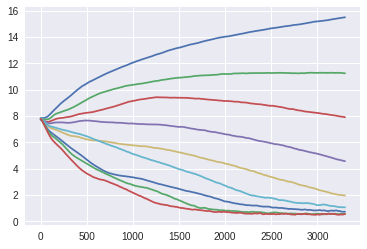

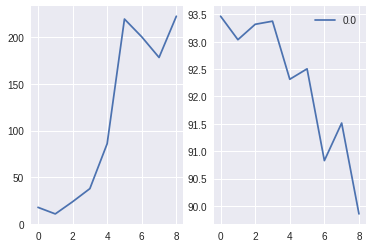

In [0]:
sidx = int((N_INPUTS+N_OUTPUTS+1)*N_HIDDEN)
ridx = int(N_HIDDEN*N_HIDDEN)
rval = np.asarray(regval)
rval = np.mean(rval.reshape(N_REPS,int(len(rval)/N_REPS)).T,axis=1)
plt.plot(rval.reshape(N_LAMBDA,int(len(rval)/N_LAMBDA)).T)
plt.show()
plt.subplot(1,2,1)
plt.plot(np.sum(np.abs(Phist[sidx:(sidx+ridx),-1,:,0].squeeze())<0.001,axis=0))
plt.subplot(1,2,2)
plt.plot(train_acc[-1,:,0].T)
plt.legend(lambdas)
plt.show()

In [4]:
# moving everything to gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# a custom RNN that is the correct discretized version of the continous dynamic
class PRNN(nn.Module):
    def __init__(self, n_inputs, n_hidden,n_output,dt,device):
        super(PRNN, self).__init__()
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_output = n_output
        self.dt = nn.Parameter(torch.Tensor([dt]))
        self.a = nn.Parameter(torch.Tensor([1]))
        self.sig = nn.Sigmoid()
        self.decoder = nn.Linear(n_hidden, n_output)
        self.encoder = nn.Linear(n_inputs, n_hidden)
        self.recurrent = nn.Linear(n_hidden,n_hidden)
        
    def forward(self, x0):
        x0=x0.permute(1,0,2)
        self.h1 = torch.zeros(1,BATCH_SIZE,self.n_hidden).to(device)
        for i in range(x0.size(0)):
            self.h1 = (1-self.sig(self.dt))*self.h1+self.sig(self.dt)*torch.tanh(self.encoder(x0[i,:,:])+self.recurrent(self.h1))
        self.y1 = self.decoder(self.h1)
        
        return self.y1

cuda:0


In [5]:
# parameters 
N_STEPS = 28
N_INPUTS = 28
N_HIDDEN = 100
N_OUTPUTS = 10
N_EPHOCS = 11
N_REPS = 2
lambdas = np.asarray([0,0.5,1,2,4,8])
N_LAMBDA = len(lambdas)
gidx = int(N_HIDDEN/2)

def nparam(ninputs,nhidden,noutputs):
    return ninputs*(nhidden+1) + nhidden*(nhidden+1)+nhidden*(noutputs+1)
N_PARAMS = nparam(N_INPUTS,N_HIDDEN,N_OUTPUTS)

In [15]:
# regularizing digonal blocks of the partitioned RNN
train_loss_P = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
train_acc_P = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_acc_P = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
Phist_P = np.zeros((N_PARAMS,N_EPHOCS,N_LAMBDA,N_REPS))

model_P =  [None] * N_LAMBDA*N_REPS
regval_P = []
for r in range(N_REPS):
    print('rep = {}\n'.format(r))
    for k, reg_lambda in enumerate(tqdm(lambdas)):
        model_P[k+r*N_REPS] = PRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,1,device).to(device)
        optimizer = torch.optim.SGD(model_P[k+r*N_REPS].parameters(), lr=2e-2, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        #print('lambda = {}'.format(reg_lambda))
        for epoch in tqdm(range(N_EPHOCS)):
            nps = 0
            running_loss=0
            running_acc=0
            for p,param in enumerate(model_P[k+r*N_REPS].parameters()):
                if param.requires_grad:
                    plist = torch.flatten(param.data)
                    for j in range(plist.size(0)):
                        Phist_P[nps,epoch,k,r]=plist[j]
                        nps+=1

            for i, data in enumerate(trainloader):
                optimizer.zero_grad()
                x, y_tar = data
                x, y_tar = x.to(device), y_tar.to(device)
                y_pred = model_P[k+r*N_REPS](x.view(BATCH_SIZE,N_STEPS,N_INPUTS))
                loss = criterion(y_pred.view(BATCH_SIZE,N_OUTPUTS),y_tar)
                l2_reg = Variable(torch.FloatTensor(1), requires_grad=True).to(device)
                l2_reg = 0
                for p,param in enumerate(model_P[k+r*N_REPS].parameters()):
                    if param.requires_grad and len(param.shape)==2:
                        if param.shape[0]==N_HIDDEN and param.shape[1]==N_HIDDEN:
                            l2_reg = l2_reg + param[:gidx,:gidx].norm(p=1)
                            l2_reg = l2_reg + param[gidx:,gidx:].norm(p=1)
                        elif param.shape[1]==N_HIDDEN:
                            l2_reg = l2_reg + param[:,gidx:].norm(p=1)
                        elif param.shape[0]==N_HIDDEN:
                            l2_reg = l2_reg + param[:gidx,:].norm(p=1)
                regval_P.append(l2_reg)
                loss = loss + l2_reg*reg_lambda/BATCH_SIZE
                loss.backward()
                optimizer.step()
                running_loss+=loss.item()
                running_acc+=get_accuracy(y_pred.view(BATCH_SIZE,N_OUTPUTS), y_tar)

            running_test_acc=0
            for i,data in enumerate(testloader):
                x_test, y_test_tar = data
                x_test, y_test_tar = x_test.to(device), y_test_tar.to(device)
                y_test_pred = model_P[k+r*N_REPS](x_test.view(BATCH_SIZE,N_STEPS,N_INPUTS))
                running_test_acc+=get_accuracy(y_test_pred.view(BATCH_SIZE,N_OUTPUTS), y_test_tar)
            train_loss_P[epoch,k,r] = running_loss/len(trainloader)
            train_acc_P[epoch,k,r] = running_acc/len(trainloader)
            test_acc_P[epoch,k,r] = running_test_acc/len(testloader)

rep = 0




rep = 1



In [21]:
# regularizing random elements of the matrix
train_loss_R = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
train_acc_R = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_acc_R = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
Phist_R = np.zeros((N_PARAMS,N_EPHOCS,N_LAMBDA,N_REPS))

model_R =  [None] * N_LAMBDA*N_REPS
regval_R = []
for r in range(N_REPS):
    # generate a random binary mask for the parameter
    rndmask = torch.FloatTensor(N_HIDDEN, N_HIDDEN).uniform_() > 0.5
    while not rndmask.float().norm(p=1)==int(N_HIDDEN**2/2):
        if rndmask.float().norm(p=1)>int(N_HIDDEN**2/2):
            while True:
                rndidx = np.random.randint(N_HIDDEN,size=(2))
                if rndmask[rndidx[0],rndidx[1]]==1:
                    rndmask[rndidx[0],rndidx[1]]=0
                    break
        else:
            while True:
                rndidx = np.random.randint(N_HIDDEN,size=(2))
                if rndmask[rndidx[0],rndidx[1]]==0:
                    rndmask[rndidx[0],rndidx[1]]=1
                    break
    rndmask = rndmask.to(device)
    print('rep = {}\n'.format(r))
    for k, reg_lambda in enumerate(tqdm(lambdas)):
        model_R[k+r*N_REPS] = PRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,1,device).to(device)
        optimizer = torch.optim.SGD(model_R[k+r*N_REPS].parameters(), lr=2e-2, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        #print('lambda = {}'.format(reg_lambda))

        for epoch in tqdm(range(N_EPHOCS)):
            nps = 0
            running_loss=0
            running_acc=0
            for p,param in enumerate(model_R[k+r*N_REPS].parameters()):
                if param.requires_grad:
                    plist = torch.flatten(param.data)
                    for j in range(plist.size(0)):
                        Phist_R[nps,epoch,k,r]=plist[j]
                        nps+=1

            for i, data in enumerate(trainloader):
                optimizer.zero_grad()
                x, y_tar = data
                x, y_tar = x.to(device), y_tar.to(device)
                y_pred = model_R[k+r*N_REPS](x.view(BATCH_SIZE,N_STEPS,N_INPUTS))
                loss = criterion(y_pred.view(BATCH_SIZE,N_OUTPUTS),y_tar)
                l2_reg = Variable(torch.FloatTensor(1), requires_grad=True).to(device)
                l2_reg = 0
                for p,param in enumerate(model_R[k+r*N_REPS].parameters()):
                    if param.requires_grad and len(param.shape)==2:
                        if param.shape[0]==N_HIDDEN and param.shape[1]==N_HIDDEN:
                            l2_reg = l2_reg + torch.masked_select(param,rndmask).norm(p=1)
                        elif param.shape[1]==N_HIDDEN:
                            l2_reg = l2_reg + param[:,gidx:].norm(p=1)
                        elif param.shape[0]==N_HIDDEN:
                            l2_reg = l2_reg + param[:gidx,:].norm(p=1)
                regval_R.append(l2_reg)
                loss = loss + l2_reg*reg_lambda/BATCH_SIZE
                loss.backward()
                optimizer.step()
                running_loss+=loss.item()
                running_acc+=get_accuracy(y_pred.view(BATCH_SIZE,N_OUTPUTS), y_tar)
              
            running_test_acc=0
            for i,data in enumerate(testloader):
                x_test, y_test_tar = data
                x_test, y_test_tar = x_test.to(device), y_test_tar.to(device)
                y_test_pred = model_R[k+r*N_REPS](x_test.view(BATCH_SIZE,N_STEPS,N_INPUTS))
                running_test_acc+=get_accuracy(y_test_pred.view(BATCH_SIZE,N_OUTPUTS), y_test_tar)
              
            train_loss_R[epoch,k,r] = running_loss/len(trainloader)
            train_acc_R[epoch,k,r] = running_acc/len(trainloader)
            test_acc_R[epoch,k,r] = running_test_acc/len(testloader)

rep = 0




rep = 1



In [6]:
# regularizing off-digonal blocks of the partitioned RNN
train_loss_C = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
train_acc_C = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
test_acc_C = np.zeros((N_EPHOCS,N_LAMBDA,N_REPS))
Phist_C = np.zeros((N_PARAMS,N_EPHOCS,N_LAMBDA,N_REPS))

model_C =  [None] * N_LAMBDA*N_REPS
regval_C = []
for r in range(N_REPS):
    print('rep = {}\n'.format(r))
    for k, reg_lambda in enumerate(tqdm(lambdas)):
        model_C[k+r*N_REPS] = PRNN(N_INPUTS,N_HIDDEN,N_OUTPUTS,1,device).to(device)
        optimizer = torch.optim.SGD(model_C[k+r*N_REPS].parameters(), lr=2e-2, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        #print('lambda = {}'.format(reg_lambda))

        for epoch in range(N_EPHOCS):
            nps = 0
            running_loss=0
            running_acc=0
            for p,param in enumerate(model_C[k+r*N_REPS].parameters()):
                if param.requires_grad:
                    plist = torch.flatten(param.data)
                    for j in range(plist.size(0)):
                        Phist_C[nps,epoch,k,r]=plist[j]
                        nps+=1

            for i, data in enumerate(trainloader):
                optimizer.zero_grad()
                x, y_tar = data
                x, y_tar = x.to(device), y_tar.to(device)
                y_pred = model_C[k+r*N_REPS](x.view(BATCH_SIZE,N_STEPS,N_INPUTS))
                loss = criterion(y_pred.view(BATCH_SIZE,N_OUTPUTS),y_tar)
                l2_reg = Variable(torch.FloatTensor(1), requires_grad=True).to(device)
                l2_reg = 0
                for p,param in enumerate(model_C[k+r*N_REPS].parameters()):
                    if param.requires_grad and len(param.shape)==2:
                        if param.shape[0]==N_HIDDEN and param.shape[1]==N_HIDDEN:
                            l2_reg = l2_reg + param[:gidx,gidx:].norm(p=1)
                            l2_reg = l2_reg + param[gidx:,:gidx].norm(p=1)
                        elif param.shape[1]==N_HIDDEN:
                            l2_reg = l2_reg + param[:,gidx:].norm(p=1)
                        elif param.shape[0]==N_HIDDEN:
                            l2_reg = l2_reg + param[:gidx,:].norm(p=1)
                regval_C.append(l2_reg)
                loss = loss + l2_reg*reg_lambda/BATCH_SIZE
                loss.backward()
                optimizer.step()
                running_loss+=loss.item()
                running_acc+=get_accuracy(y_pred.view(BATCH_SIZE,N_OUTPUTS), y_tar)
              
            running_test_acc=0
            for i,data in enumerate(testloader):
                x_test, y_test_tar = data
                x_test, y_test_tar = x_test.to(device), y_test_tar.to(device)
                y_test_pred = model_C[k+r*N_REPS](x_test.view(BATCH_SIZE,N_STEPS,N_INPUTS))
                running_test_acc+=get_accuracy(y_test_pred.view(BATCH_SIZE,N_OUTPUTS), y_test_tar)
              
            train_loss_C[epoch,k,r] = running_loss/len(trainloader)
            train_acc_C[epoch,k,r] = running_acc/len(trainloader)
            test_acc_C[epoch,k,r] = running_test_acc/len(testloader)

rep = 0




rep = 1



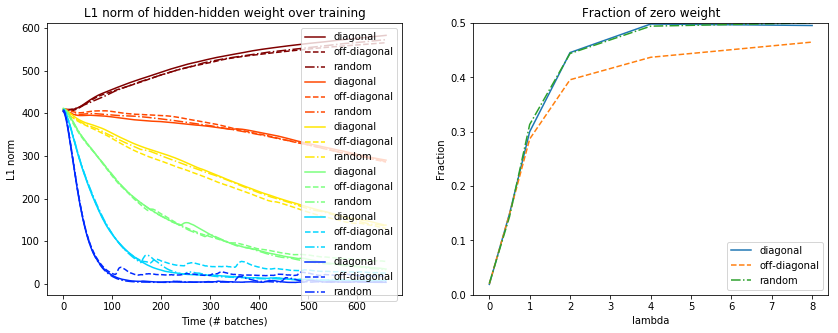

In [22]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sidx = int((N_INPUTS+N_OUTPUTS+1)*N_HIDDEN)
ridx = int(N_HIDDEN*N_HIDDEN)
rval_P = np.asarray(regval_P)
rval_P = np.mean(rval_P.reshape(N_REPS,int(len(rval_P)/N_REPS)).T,axis=1)
rval_P = rval_P.reshape(N_LAMBDA,int(len(rval_P)/N_LAMBDA)).T
rval_C = np.asarray(regval_C)
rval_C = np.mean(rval_C.reshape(N_REPS,int(len(rval_C)/N_REPS)).T,axis=1)
rval_C = rval_C.reshape(N_LAMBDA,int(len(rval_C)/N_LAMBDA)).T
rval_R = np.asarray(regval_R)
rval_R = np.mean(rval_R.reshape(N_REPS,int(len(rval_R)/N_REPS)).T,axis=1)
rval_R = rval_R.reshape(N_LAMBDA,int(len(rval_R)/N_LAMBDA)).T
cmap = plt.get_cmap('jet_r')
for i in range(N_LAMBDA):
    plt.plot(rval_P[:,i],'-',c=cmap(float(i)/N_LAMBDA),label='diagonal')
    plt.plot(rval_C[:,i],'--',c=cmap(float(i)/N_LAMBDA),label='off-diagonal')
    plt.plot(rval_R[:,i],'-.',c=cmap(float(i)/N_LAMBDA),label='random')
plt.legend()
plt.title('L1 norm of hidden-hidden weight over training')
plt.ylabel('L1 norm')
plt.xlabel('Time (# batches)')
plt.subplot(1,2,2)
plt.plot(lambdas,np.mean(np.sum(np.abs(Phist_P[sidx:(sidx+ridx),-1,:,:].squeeze())<0.0025,axis=0),axis=1)/ridx,'-',label='diagonal')
plt.plot(lambdas,np.mean(np.sum(np.abs(Phist_C[sidx:(sidx+ridx),-1,:,:].squeeze())<0.0025,axis=0),axis=1)/ridx,'--',label='off-diagonal')
plt.plot(lambdas,np.mean(np.sum(np.abs(Phist_R[sidx:(sidx+ridx),-1,:,:].squeeze())<0.0025,axis=0),axis=1)/ridx,'-.',label='random')
plt.ylim((0,.5))
plt.legend()
plt.title('Fraction of zero weight')
plt.xlabel('lambda')
plt.ylabel('Fraction')
plt.show()

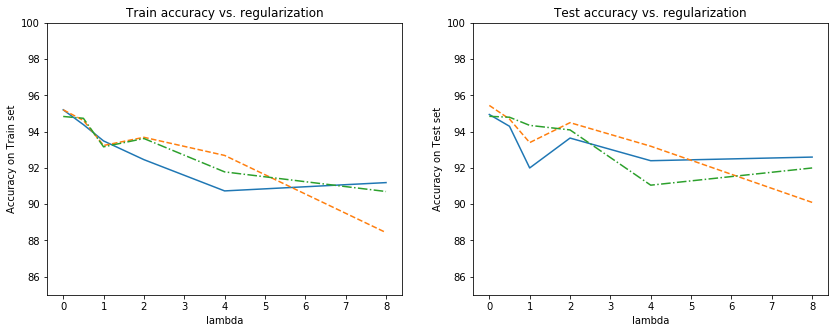

In [25]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(lambdas,np.mean(train_acc_P[-1,:,:].squeeze(),axis = 1).T,'-')
plt.plot(lambdas,np.mean(train_acc_C[-1,:,:].squeeze(),axis = 1).T,'--')
plt.plot(lambdas,np.mean(train_acc_R[-1,:,:].squeeze(),axis = 1).T,'-.')
plt.ylim((85,100))
plt.title('Train accuracy vs. regularization')
plt.xlabel('lambda')
plt.ylabel('Accuracy on Train set')
plt.subplot(1,2,2)
plt.plot(lambdas,np.mean(test_acc_P[-1,:,:].squeeze(),axis = 1).T,'-')
plt.plot(lambdas,np.mean(test_acc_C[-1,:,:].squeeze(),axis = 1).T,'--')
plt.plot(lambdas,np.mean(test_acc_R[-1,:,:].squeeze(),axis = 1).T,'-.')
plt.ylim((85,100))
plt.title('Test accuracy vs. regularization')
plt.xlabel('lambda')
plt.ylabel('Accuracy on Test set')
plt.show()

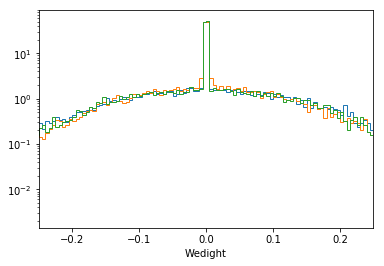

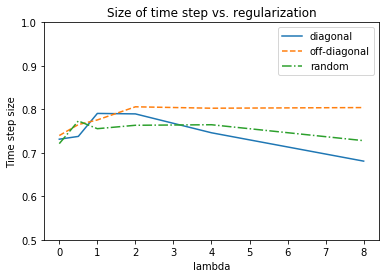

In [28]:
plt.hist(Phist_P[:,-1,-1,0],label=lambdas[0],normed=1, histtype='step',bins=np.arange(-0.5,0.5,0.005),log=True)
plt.hist(Phist_C[:,-1,-1,0],label=lambdas[1],normed=1, histtype='step',bins=np.arange(-0.5,0.5,0.005),log=True)
plt.hist(Phist_R[:,-1,-1,0],label=lambdas[2],normed=1, histtype='step',bins=np.arange(-0.5,0.5,0.005),log=True)
plt.xlim((-.25,.25))
plt.xlabel('Wedight')
plt.show()

plt.plot(lambdas,1/(1+np.exp(-np.mean(Phist_P[0,-1,:,:],axis=1).squeeze())),'-',label='diagonal')
plt.plot(lambdas,1/(1+np.exp(-np.mean(Phist_C[0,-1,:,:],axis=1).squeeze())),'--',label='off-diagonal')
plt.plot(lambdas,1/(1+np.exp(-np.mean(Phist_R[0,-1,:,:],axis=1).squeeze())),'-.',label='random')
plt.ylim((0.5,1))
plt.legend()
plt.title('Size of time step vs. regularization')
plt.ylabel('Time step size')
plt.xlabel('lambda')
plt.show()